In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

from scipy.linalg import hilbert
import scipy.linalg as sl

### Classical Gram-Schmidt

In [2]:
def cgs(A):
    """
    Produces a thin-QR factorization
    
    Use scipy.linalg.qr instead of this code 
    

    """
    
    m, n = A.shape
    Q = np.zeros((m,n), dtype = 'd')
    R = np.zeros((n,n), dtype = 'd')
    
    R[0,0] = np.linalg.norm(A[:,0])
    Q[:,0] = A[:,0]/R[0,0]
    
    for k in range(1,n):
        
        R[:k,k] = Q[:,:k].T@A[:,k]
        z = A[:,k] - Q[:,:k] @R[:k,k]
        R[k,k] = np.linalg.norm(z)
        Q[:,k] = z/R[k,k]
        
    return Q, R
    

def test_cgs(A):
    m,n = A.shape
    
    
    Q,R = cgs(A)
    print('Error in ||A - Q_1R||_2/ ||A||_2', np.linalg.norm(A - Q@R,2)/np.linalg.norm(A,2))
    print('Error in ||Q_1^TQ_1 - I_n||_2', np.linalg.norm(Q.T@ Q - np.eye(n),2))
    print('Error in ||Q_1^TA - R||_2/ ||A||_2', np.linalg.norm(Q.T@ A - R,2)/np.linalg.norm(A,2))
    print('Error in ||AR^{-1} - Q_1||_2', np.linalg.norm(np.linalg.solve(R.T,A.T).T - Q,2))
    
    return


A = np.random.randn(100,30)
test_cgs(A)

Error in ||A - Q_1R||_2/ ||A||_2 1.2272619018100189e-16
Error in ||Q_1^TQ_1 - I_n||_2 8.257560558914495e-16
Error in ||Q_1^TA - R||_2/ ||A||_2 4.1958594630395525e-16
Error in ||AR^{-1} - Q_1||_2 3.290109663173421e-16


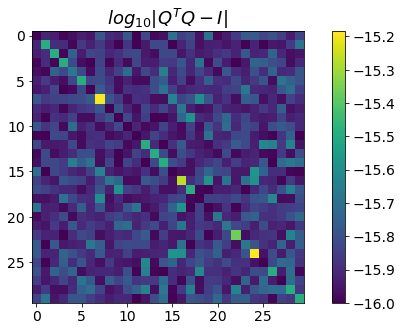

In [3]:
Q, R = cgs(A)

D = Q.T @ Q - np.eye(A.shape[1])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

What about the Hilbert matrix?

Error in ||A - Q_1R||_2/ ||A||_2 4.3777892530931054e-17


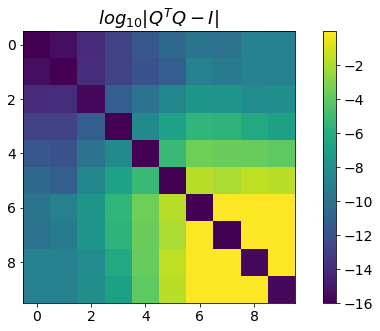

In [4]:
A = hilbert(10)
Q, R = cgs(A)

D = Q.T @ Q - np.eye(A.shape[1])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

print('Error in ||A - Q_1R||_2/ ||A||_2', np.linalg.norm(A - Q@R,2)/np.linalg.norm(A,2))

Conclusions:
    
+ CGS is not numerically stable. Loses orthogonality very quickly.
+ However, error in $\|A -Q_1R\|_2/\|A\|_2$ is very good!
+ The first point is an issue since we need $Q_1^TQ_1 \approx I$

### Modified Gram-Schmidt

In [5]:
def mgs(A):
    """
    Produces a thin-QR factorization
    using modified Gram-Schmidt
    
    Use scipy.linalg.qr 
    
    """
    
    m, n = A.shape
    Q = np.zeros((m,n), dtype = 'd')
    R = np.zeros((n,n), dtype = 'd')
    
    
    Am = np.copy(A)
    for k in range(n):
        R[k,k] = np.linalg.norm(Am[:,k])
        Q[:,k] = Am[:,k]/R[k,k]
        for j in range(k+1,n):
            R[k,j] = np.inner(Q[:,k],Am[:,j])
            Am[:,j] = Am[:,j] -Q[:,k]*R[k,j]

    return Q,R

def test_mgs(A):
    m,n = A.shape
    
    
    Q,R = mgs(A)
    print('Error in ||A - QR||_2/ ||A||_2', np.linalg.norm(A - Q@R,2)/np.linalg.norm(A,2))
    print('Error in ||Q^TQ - I_n||_2', np.linalg.norm(Q.T@ Q - np.eye(n),2))
    print('Error in ||Q^TA - R||_2/ ||A||_2', np.linalg.norm(Q.T@ A - R,2)/np.linalg.norm(A,2))
    print('Error in ||AR^{-1} - Q||_2', np.linalg.norm(np.linalg.solve(R.T,A.T).T - Q,2))
    
    return


A = np.random.randn(100,30)
test_mgs(A)

Error in ||A - QR||_2/ ||A||_2 2.0749620201318727e-16
Error in ||Q^TQ - I_n||_2 7.054864313595993e-16
Error in ||Q^TA - R||_2/ ||A||_2 3.679359555189058e-16
Error in ||AR^{-1} - Q||_2 4.06235318348393e-16


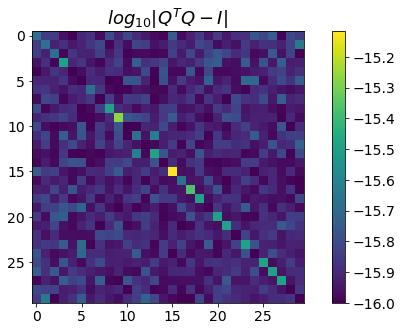

In [6]:
Q, R = mgs(A)

D = Q.T @ Q - np.eye(A.shape[1])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

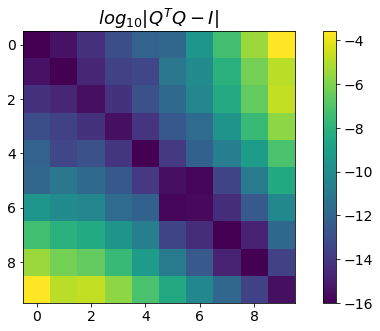

In [7]:


A = hilbert(10)


Q, R = mgs(A)
D = Q.T @ Q - np.eye(A.shape[1])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

### Givens rotations



In [8]:
def givens(x1,x2):
    """
    Implements Givens rotations
    
    c = x1/sqrt(x1^2 + x2^2)
    s = -x2/sqrt(x1^2 + x2^2)
    
    """
    
    alpha = np.sqrt(x1**2 + x2**2)
    
    if alpha > 10**(-16):
        c, s = x1/alpha, -x2/alpha
    else:
        c, s = 1, 0

    return c, s

def givensqr(A):
    """
    Compute A = Q[R; 0] 
    using a sequence of Givens rotations
    
    """
    
    m,n = A.shape
    
    
    Q = np.eye((m), dtype = 'd')
    R = np.zeros((m,n), dtype = 'd')
    
    # Initially copy A to R and overwrite the entries
    R = np.copy(A)
    
    for j in range(n):     #Outer loop across columns
        for i in range(m-1,j,-1): #Inner loop across rows
            c,s = givens(R[i-1,j], R[i,j])
            
            #Create Q explicitly
            Qt = np.eye(m)
            Qt[i-1,i-1] = c
            Qt[i,i]     = c
            Qt[i-1,i]   = -s
            Qt[i,i-1]   = s
            Q = Q @ Qt.T;
            
            
            #Overwrite R
            R[i-1:i+1,j:] = np.array([[c,-s], [s,c]]) @ R[i-1:i+1,j:]
            
    return Q, R

def test_givens(m,n):
    
    A  = np.random.randn(m,n)
    Q, R = givensqr(A)
    

    print('Error in ||A - Q[R; 0]||_2/ ||A||_2', np.linalg.norm(A - Q@R,2)/np.linalg.norm(A,2))
    print('Error in ||Q^TQ - I_m||_2', np.linalg.norm(Q.T@ Q - np.eye(m),2))
    print('Error in ||Q^TA - R||_2/ ||A||_2', np.linalg.norm(Q.T@ A - R,2)/np.linalg.norm(A,2))
    
    # Compute a thin QR factorization for the next measure
    Q1 = Q[:,:n]
    R  = R[:n,:n]
    print('Error in ||AR^{-1} - Q_1||_2', np.linalg.norm(np.linalg.solve(R.T,A.T).T - Q1,2))
    
test_givens(4,3)

Error in ||A - Q[R; 0]||_2/ ||A||_2 3.0398528469856185e-16
Error in ||Q^TQ - I_m||_2 4.68678819981263e-16
Error in ||Q^TA - R||_2/ ||A||_2 1.8851183464387234e-16
Error in ||AR^{-1} - Q_1||_2 3.231493860397021e-16


All the errors look good. We now check the orthogonality of Q in a bit more detail.

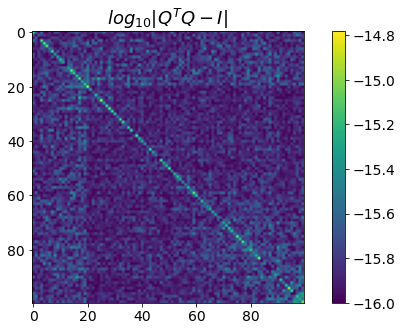

In [9]:
A = np.random.randn(100,20)
Q, R = givensqr(A)

D = Q.T @ Q - np.eye(A.shape[0])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

Let's try it on the Hilbert matrix.

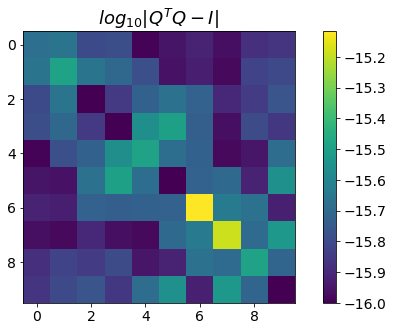

In [10]:

A = hilbert(10)
Q, R = givensqr(A)
D = Q.T @ Q - np.eye(A.shape[1])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

### Householder QR 

Householder QR involves a sequence of Householder transformations of the form 
$$ H_n \cdots H_1 A = \begin{bmatrix} R \\ 0 \end{bmatrix} ,$$

where $$H_i = \begin{bmatrix} I & 0 \\ 0  & I- 2u_iu_i^T \end{bmatrix}.$$


In [11]:
def householder(x):
    """
    Given a nonzero vector x, compute 
    
    H = I - 2uu^T
    
    where u = x +sign(x)e_1
    
    """
    
    n = x.size
    alpha = np.sign(x[0])

    e1 = np.zeros((n,), dtype = 'd')
    e1[0] = np.linalg.norm(x)
    v = x + alpha*e1
    
    u = v/np.linalg.norm(v)
    H = np.eye(n) - 2*np.outer(u,u)
    
    
    return u, H
    
    
def householderQR(A):
    """
    Reduces A to upper triangular form [R; 0]
    using a sequence of Householder QR reflections
    
    Terribly inefficient. Only for understanding
    
    """
    
    m,n = A.shape
    
    # Construct Q matrix
    Q = np.eye((m), dtype = 'd')
    # Initially copy A to R and overwrite the entries
    R = np.copy(A)
    
    for j in range(n):
        
        u, H = householder(R[j:,j])
        
        #Update R
        R[j:,j:] =  H @ R[j:,j:]
        
        #Update Q
        if j == 0:
            Q = Q @ H
        else:
            # Embed Householder matrix as H_j = [I_j 0; 0 H_j']
            Q = Q @ np.bmat([[np.eye(j),np.zeros((j,m-j)) ],[np.zeros((m-j,j)),H]])
        
    return Q, R
        
def test_householder(m,n):
    
    A  = np.random.randn(m,n)
    Q, R = householderQR(A)
    
    print('Error in ||A - Q[R; 0]||_2/ ||A||_2', np.linalg.norm(A - Q@R,2)/np.linalg.norm(A,2))
    print('Error in ||Q^TQ - I_m||_2', np.linalg.norm(Q.T@ Q - np.eye(m),2))
    print('Error in ||Q^TA - R||_2/ ||A||_2', np.linalg.norm(Q.T@ A - R,2)/np.linalg.norm(A,2))
    
    # Compute a thin QR factorization for the next measure
    Q1 = Q[:,:n]
    R  = R[:n,:n]
    print('Error in ||AR^{-1} - Q_1||_2', np.linalg.norm(np.linalg.solve(R.T,A.T).T - Q1,2))
    
test_householder(5,3)

Error in ||A - Q[R; 0]||_2/ ||A||_2 5.94881935738481e-16
Error in ||Q^TQ - I_m||_2 6.837301565055011e-16
Error in ||Q^TA - R||_2/ ||A||_2 1.5039314275572234e-16
Error in ||AR^{-1} - Q_1||_2 6.125906012017964e-16


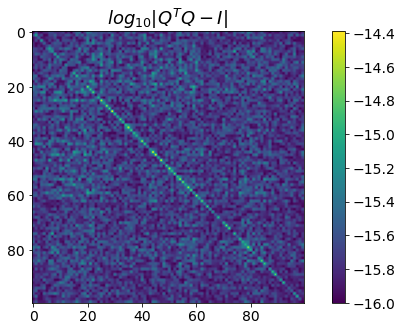

In [12]:
A = np.random.randn(100,20)
Q, R = householderQR(A)

D = Q.T @ Q - np.eye(A.shape[0])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

Householder vs Hilbert

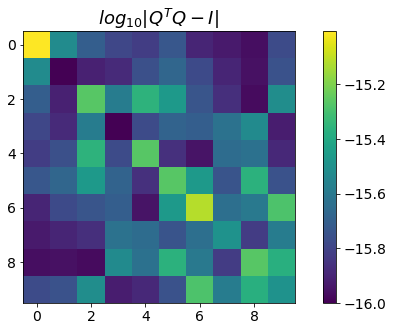

In [13]:
A = hilbert(10)
Q, R = householderQR(A)

D = Q.T @ Q - np.eye(A.shape[0])
plt.imshow(np.log10(np.abs(D) + 1.e-16) )
plt.title('$log_{10}|Q^TQ - I|$', fontsize = 18)
plt.colorbar()

### Normal equations vs QR 

In [14]:
t = np.linspace(0,1,100)
A = t[:,np.newaxis]**np.arange(10)

# True solution and right hand side
xt = np.ones((10,), dtype = 'd')
bt = A @ xt

#### Solve using normal equations

The normal equations are 
$$ A^TAx = A^T b .$$

In [20]:
#Solve using normal equations

AtA = A.T @ A
Atb = A.T@ bt

xn = sl.solve(AtA, Atb)
print('relative error using normal equations', np.linalg.norm(xn-xt)/np.linalg.norm(xt))

relative error using normal equations 0.00020800834008111648


#### Solve using QR 

Factorize $A = Q_1 R$ and solve the normal equations as 

$$ Rx = Q_1^T b. $$

In [16]:
Q1, R = sl.qr(A, mode = 'economic')
xqr = sl.solve(R, Q1.T @ bt)

print('relative error using QR', np.linalg.norm(xqr-xt)/np.linalg.norm(xt))

relative error using QR 1.8936727974882373e-11


The major culprit is $A$, which is ill-conditioned. Below we display the condition number of $A$ and $A^T A$.

In [17]:
print(np.linalg.cond(A), np.linalg.cond(AtA))

3720104.41087314 13837633999840.445
